In [1]:
import chess
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.models import resnet50
from torchvision.models.resnet import Bottleneck
from typing import List, Tuple
import torch.optim as optim
import time
from tqdm import tqdm

seed = 123456
np.random.seed(seed=seed)

# Разработка модели


In [2]:
class DualHeadChessDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)

        self._validate_data()
        self.piece_to_idx = {
            "P": 0,
            "N": 1,
            "B": 2,
            "R": 3,
            "Q": 4,
            "K": 5,
            "p": 6,
            "n": 7,
            "b": 8,
            "r": 9,
            "q": 10,
            "k": 11,
        }

    def _validate_data(self):
        valid_indices = []
        for idx, row in self.df.iterrows():
            try:
                board = chess.Board(row["fen"])
                move = chess.Move.from_uci(row["move"])
                if move in board.legal_moves:
                    valid_indices.append(idx)
            except:
                continue

        self.df = self.df.loc[valid_indices].reset_index(drop=True)
        print(f"Загружено {len(self.df)} валидных позиций")

    def _board_to_tensor(self, fen: str) -> torch.Tensor:
        board = chess.Board(fen)
        tensor = torch.zeros(20, 8, 8, dtype=torch.float32)

        # Фигуры (плоскости 0-11)
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                row, col = square // 8, square % 8
                piece_idx = self.piece_to_idx[piece.symbol()]
                tensor[piece_idx, row, col] = 1.0

        # Чей ход (плоскость 12)
        tensor[12] = 1.0 if board.turn else 0.0

        # Рокировки (плоскости 13-16)
        castling_rights = [
            board.has_kingside_castling_rights(chess.WHITE),
            board.has_queenside_castling_rights(chess.WHITE),
            board.has_kingside_castling_rights(chess.BLACK),
            board.has_queenside_castling_rights(chess.BLACK),
        ]
        for i, has_right in enumerate(castling_rights):
            if has_right:
                tensor[13 + i] = 1.0

        # Взятие на проходе (плоскость 17)
        if board.ep_square is not None:
            row, col = board.ep_square // 8, board.ep_square % 8
            tensor[17, row, col] = 1.0

        # Счетчик полуходов (плоскость 18)
        tensor[18] = board.halfmove_clock / 50.0

        # Номер хода (плоскость 19)
        tensor[19] = board.fullmove_number / 500.0

        return tensor

    def _move_to_dual_labels(self, move_uci: str, fen: str) -> tuple:
        board = chess.Board(fen)
        move = chess.Move.from_uci(move_uci)

        from_square = move.from_square

        # Для to_square учитываем превращения
        # ДИАПАЗОН ДОЛЖЕН БЫТЬ 0-67 (68 классов)
        # print(move.promotion)
        if move.promotion:
            # Кодируем превращения: 64-68
            to_square = 64 + (move.promotion - 1)  # 64, 65, 66, 67, 68
        else:
            to_square = move.to_square  # 0-63

        # Проверяем, что to_square в правильном диапазоне
        if to_square >= 69:
            raise ValueError(f"Некорректный to_square: {to_square} для хода {move_uci}")

        return from_square, to_square

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fen = row["fen"]
        move = row["move"]

        board_tensor = self._board_to_tensor(fen)
        from_label, to_label = self._move_to_dual_labels(move, fen)

        return board_tensor, from_label, to_label

In [3]:
class ChessDataSplitter:
    def __init__(
        self,
        csv_file,
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        random_state=42,
    ):
        print(train_ratio, val_ratio, test_ratio)
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, (
            "Сумма долей должна быть равна 1"
        )

        self.csv_file = csv_file
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state

        # Загружаем полный dataset
        self.full_dataset = DualHeadChessDataset(csv_file)

    def split_data(self):
        """Разбивает данные на train/val/test"""
        # Получаем индексы
        n_total = len(self.full_dataset)
        indices = list(range(n_total))

        # Первое разбиение: отделяем test
        train_val_idx, test_idx = train_test_split(
            indices,
            test_size=self.test_ratio,
            random_state=self.random_state,
            shuffle=True,
        )

        # Второе разбиение: разделяем train и val
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=self.val_ratio / (self.train_ratio + self.val_ratio),
            random_state=self.random_state,
            shuffle=True,
        )

        # Создаем Subset datasets
        train_dataset = Subset(self.full_dataset, train_idx)
        val_dataset = Subset(self.full_dataset, val_idx)
        test_dataset = Subset(self.full_dataset, test_idx)

        print(f"Разбиение завершено:")
        print(
            f"Train: {len(train_dataset)} samples ({len(train_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Val: {len(val_dataset)} samples ({len(val_dataset) / n_total * 100:.1f}%)"
        )
        print(
            f"Test: {len(test_dataset)} samples ({len(test_dataset) / n_total * 100:.1f}%)"
        )

        return train_dataset, val_dataset, test_dataset

In [4]:
class DualHeadChessModel(nn.Module):
    def __init__(self, device="cpu"):
        super().__init__()
        self.device = device

        # ResNet-50 backbone с модификациями
        self.backbone = resnet50(pretrained=True)
        
        # 1. Заменяем первый слой для 20 каналов
        self.backbone.conv1 = nn.Conv2d(20, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # 2. Заменяем BatchNorm слои (важно!)
        # Получаем все дочерние модули
        backbone_layers = list(self.backbone.children())
        
        # 3. Убираем последние слои (avgpool и classifier)
        self.backbone = nn.Sequential(*backbone_layers[:-2])
        
        # 4. Добавляем свой adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # 5. Добавляем BatchNorm и Dropout для стабилизации
        self.from_bn1 = nn.BatchNorm1d(256)
        self.from_dropout = nn.Dropout(0.3)
        
        self.to_bn1 = nn.BatchNorm2d(256)
        self.to_bn2 = nn.BatchNorm1d(128)
        self.to_dropout = nn.Dropout(0.3)

        # Голова для исходной клетки
        self.from_fc1 = nn.Linear(2048 * 8 * 8, 256)
        self.from_output = nn.Linear(256, 64)

        # Голова для целевой клетки
        self.to_conv = nn.Conv2d(2048 + 64, 256, 3, padding=1)
        self.to_fc1 = nn.Linear(256 * 8 * 8, 128)
        self.to_output = nn.Linear(128, 69)

        # Инициализация
        self._initialize_weights()
        
        # Перенос на устройство
        self.to(device)

    def _initialize_weights(self):
        """Более безопасная инициализация"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, board_tensor, from_square=None):
        # Проверка входных данных
        if torch.isnan(board_tensor).any():
            print("Обнаружены NaN во входных данных!")
            
        # Общие признаки через ResNet
        x = self.backbone(board_tensor)
        shared_features = self.adaptive_pool(x)
        
        # Проверка промежуточных значений
        if torch.isnan(shared_features).any():
            print("NaN после backbone!")

        # Голова для исходной клетки
        from_flat = shared_features.reshape(shared_features.size(0), -1)
        from_hidden = F.relu(self.from_fc1(from_flat))
        from_hidden = self.from_bn1(from_hidden)
        from_hidden = self.from_dropout(from_hidden)
        from_logits = self.from_output(from_hidden)
        
        # Используем log_softmax для стабильности с NLLLoss
        from_probs = F.log_softmax(from_logits, dim=1)

        if from_square is None:
            return from_probs, None

        # Голова для целевой клетки
        from_onehot = torch.zeros(shared_features.size(0), 64, 8, 8, device=self.device)
        from_onehot[torch.arange(shared_features.size(0)), from_square, :, :] = 1

        to_input = torch.cat([shared_features, from_onehot], dim=1)
        to_features = F.relu(self.to_conv(to_input))
        to_features = self.to_bn1(to_features)
        
        to_flat = to_features.reshape(to_features.size(0), -1)
        to_hidden = F.relu(self.to_fc1(to_flat))
        to_hidden = self.to_bn2(to_hidden)
        to_hidden = self.to_dropout(to_hidden)
        to_logits = self.to_output(to_hidden)
        to_probs = F.log_softmax(to_logits, dim=1)

        return from_probs, to_probs

In [5]:
class ChessTrainer:
    def __init__(self
                 ,model
                 ,train_loader
                 ,val_loader
                 ,test_loader
                 ,device="cpu"
                 ,lr=0.01
                 ,weight_decay = 0.1
                ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.lr = lr
        self.weight_decay = weight_decay

        # Функции потерь
        self.from_criterion = nn.NLLLoss()
        self.to_criterion = nn.NLLLoss()

        # Оптимизатор
        self.optimizer = optim.AdamW(model.parameters(), lr=self.lr, weight_decay = self.weight_decay, amsgrad=True)

        # Планировщик learning rate
        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=5, gamma=0.5
        )

        # История обучения
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_from_acc": [],
            "val_from_acc": [],
            "train_to_acc": [],
            "val_to_acc": [],
            "learning_rate": [],
        }

    def train_epoch(self):
        """Одна эпоха обучения"""
        self.model.train()
        total_loss = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        train_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, (boards, from_targets, to_targets) in enumerate(train_bar):
            # Перемещаем данные на device
            boards = boards.to(self.device)
            from_targets = from_targets.to(self.device)
            to_targets = to_targets.to(self.device)

            # Обнуляем градиенты
            self.optimizer.zero_grad()

            # Прямой проход
            from_probs, to_probs = self.model(boards, from_targets)

            # Вычисляем потери
            # print(to_probs, to_targets)
            from_loss = self.from_criterion(from_probs, from_targets)
            to_loss = self.to_criterion(to_probs, to_targets)
            loss = from_loss + to_loss

            # Обратный проход
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Шаг оптимизатора
            self.optimizer.step()

            # Статистика
            total_loss += loss.item()
            batch_size = boards.size(0)
            total_samples += batch_size

            # Точность для from-square
            from_preds = torch.argmax(from_probs, dim=1)
            from_correct = (from_preds == from_targets).sum().item()
            total_from_correct += from_correct

            # Точность для to-square
            to_preds = torch.argmax(to_probs, dim=1)
            to_correct = (to_preds == to_targets).sum().item()
            total_to_correct += to_correct

            # Обновляем progress bar
            train_bar.set_postfix(
                {
                    "Loss": f"{loss.item():.4f}",
                    "From Acc": f"{from_correct / batch_size:.3f}",
                    "To Acc": f"{to_correct / batch_size:.3f}",
                }
            )

        # Вычисляем средние метрики за эпоху
        avg_loss = total_loss / len(self.train_loader)
        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples

        return avg_loss, from_acc, to_acc

    def validate(self):
        """Валидация модели"""
        self.model.eval()
        total_loss = 0
        total_from_correct = 0
        total_to_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.val_loader, desc="Validation"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Прямой проход
                from_probs, to_probs = self.model(boards, from_targets)

                # Потери
                from_loss = self.from_criterion(from_probs, from_targets)
                to_loss = self.to_criterion(to_probs, to_targets)
                loss = from_loss + to_loss

                total_loss += loss.item()
                batch_size = boards.size(0)
                total_samples += batch_size

                # Точность
                from_preds = torch.argmax(from_probs, dim=1)
                # print(from_probs, from_preds, from_targets)
                from_correct = (from_preds == from_targets).sum().item()
                total_from_correct += from_correct

                to_preds = torch.argmax(to_probs, dim=1)
                to_correct = (to_preds == to_targets).sum().item()
                total_to_correct += to_correct

        avg_loss = total_loss / len(self.val_loader)
        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples

        return avg_loss, from_acc, to_acc

    def train(self, num_epochs=50, early_stopping_patience=10):
        """Полный цикл обучения"""
        best_val_loss = float("inf")
        patience_counter = 0

        print("Начало обучения...")
        print(f"Используется устройство: {self.device}")
        print(f"Размер тренировочного набора: {len(self.train_loader.dataset)}")
        print(f"Размер валидационного набора: {len(self.val_loader.dataset)}")

        for epoch in range(num_epochs):
            print(f"\nЭпоха {epoch + 1}/{num_epochs}")
            print("-" * 50)

            # Обучение
            train_loss, train_from_acc, train_to_acc = self.train_epoch()

            # Валидация
            val_loss, val_from_acc, val_to_acc = self.validate()

            # Обновление learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]["lr"]

            # Сохраняем историю
            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_from_acc"].append(train_from_acc)
            self.history["val_from_acc"].append(val_from_acc)
            self.history["train_to_acc"].append(train_to_acc)
            self.history["val_to_acc"].append(val_to_acc)
            self.history["learning_rate"].append(current_lr)

            # Выводим результаты
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(
                f"Train From Acc: {train_from_acc:.4f} | Val From Acc: {val_from_acc:.4f}"
            )
            print(f"Train To Acc: {train_to_acc:.4f} | Val To Acc: {val_to_acc:.4f}")
            print(f"Learning Rate: {current_lr:.6f}")

            # Сохранение лучшей модели
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.save_model(f"best_chess_model_{self.model.__class__.__name__}.pth")
                print("Сохранена лучшая модель!")
            else:
                patience_counter += 1
                print(
                    f"Early stopping: {patience_counter}/{early_stopping_patience}"
                )

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print("Ранняя остановка!")
                break

        print("\nОбучение завершено!")

    def evaluate(self):
        """Финальная оценка на тестовом наборе"""
        print("\nОценка на тестовом наборе...")
        self.model.eval()

        total_from_correct = 0
        total_to_correct = 0
        total_full_correct = 0
        total_samples = 0

        with torch.no_grad():
            for boards, from_targets, to_targets in tqdm(
                self.test_loader, desc="Testing"
            ):
                boards = boards.to(self.device)
                from_targets = from_targets.to(self.device)
                to_targets = to_targets.to(self.device)

                # Предсказание from-square
                from_probs, _ = self.model(boards)
                from_preds = torch.argmax(from_probs, dim=1)

                # Предсказание to-square (используя правильные from-square для честной оценки)
                _, to_probs = self.model(boards, from_targets)
                to_preds = torch.argmax(to_probs, dim=1)

                # Подсчет правильных предсказаний
                from_correct = (from_preds == from_targets).sum().item()
                to_correct = (to_preds == to_targets).sum().item()
                full_correct = (
                    ((from_preds == from_targets) & (to_preds == to_targets))
                    .sum()
                    .item()
                )

                total_from_correct += from_correct
                total_to_correct += to_correct
                total_full_correct += full_correct
                total_samples += boards.size(0)

        from_acc = total_from_correct / total_samples
        to_acc = total_to_correct / total_samples
        full_acc = total_full_correct / total_samples

        print(f"\nРезультаты на тестовом наборе:")
        print(f"From-square Accuracy: {from_acc:.4f}")
        print(f"To-square Accuracy: {to_acc:.4f}")
        print(f"Full Move Accuracy: {full_acc:.4f}")

        return from_acc, to_acc, full_acc

    def save_model(self, path):
        """Сохранение модели"""
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "history": self.history,
            },
            path,
        )

    def load_model(self, path):
        """Загрузка модели"""
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.history = checkpoint["history"]

    def plot_training_history(self):
        """Визуализация истории обучения"""
        import matplotlib.pyplot as plt

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Потери
        ax1.plot(self.history["train_loss"], label="Train Loss")
        ax1.plot(self.history["val_loss"], label="Val Loss")
        ax1.set_title("Потери")
        ax1.set_xlabel("Эпоха")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        # From-square точность
        ax2.plot(self.history["train_from_acc"], label="Train From Acc")
        ax2.plot(self.history["val_from_acc"], label="Val From Acc")
        ax2.set_title("From-square Точность")
        ax2.set_xlabel("Эпоха")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        # To-square точность
        ax3.plot(self.history["train_to_acc"], label="Train To Acc")
        ax3.plot(self.history["val_to_acc"], label="Val To Acc")
        ax3.set_title("To-square Точность")
        ax3.set_xlabel("Эпоха")
        ax3.set_ylabel("Accuracy")
        ax3.legend()
        ax3.grid(True)

        # Learning rate
        ax4.plot(self.history["learning_rate"])
        ax4.set_title("Learning Rate")
        ax4.set_xlabel("Эпоха")
        ax4.set_ylabel("LR")
        ax4.grid(True)

        plt.tight_layout()
        plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
        plt.show()

In [8]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используется устройство: {device}")

    # Загрузка данных
    print("Загрузка данных...")
    splitter = ChessDataSplitter(
        test_ratio=0.01,
        val_ratio=0.2 * (1 - 0.01),
        train_ratio=0.8 * (1 - 0.01),
        csv_file="fens_training_set.csv",
    )
    train_dataset, val_dataset, test_dataset = splitter.split_data()
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=0)

    # Модель
    print("Инициализация модели...")
    model = DualHeadChessModel(device=device)

    # Тренер
    trainer = ChessTrainer(model, train_loader, val_loader, test_loader, device=device, lr=0.001, weight_decay = 0.5)

    # Обучение
    trainer.train(num_epochs=20, early_stopping_patience=15)

    trainer.plot_training_history()

    # # Сохранение финальной модели
    # trainer.save_model("final_chess_model.pth")
    # print("Модель сохранена!")

Используется устройство: cuda
Загрузка данных...
0.792 0.198 0.01
Загружено 268549 валидных позиций
Разбиение завершено:
Train: 212690 samples (79.2%)
Val: 53173 samples (19.8%)
Test: 2686 samples (1.0%)
Инициализация модели...


f:\dlml\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\dlml\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Начало обучения...
Используется устройство: cuda
Размер тренировочного набора: 212690
Размер валидационного набора: 53173

Эпоха 1/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.20it/s]


Train Loss: 6.6871 | Val Loss: 6.1128
Train From Acc: 0.0845 | Val From Acc: 0.1151
Train To Acc: 0.2097 | Val To Acc: 0.2645
Learning Rate: 0.001000
Сохранена лучшая модель!

Эпоха 2/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.13it/s]


Train Loss: 5.8626 | Val Loss: 5.7078
Train From Acc: 0.1694 | Val From Acc: 0.1856
Train To Acc: 0.2662 | Val To Acc: 0.2821
Learning Rate: 0.001000
Сохранена лучшая модель!

Эпоха 3/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.15it/s]


Train Loss: 5.5258 | Val Loss: 5.4356
Train From Acc: 0.2368 | Val From Acc: 0.2421
Train To Acc: 0.2790 | Val To Acc: 0.2903
Learning Rate: 0.001000
Сохранена лучшая модель!

Эпоха 4/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.20it/s]


Train Loss: 5.3876 | Val Loss: 5.3467
Train From Acc: 0.2612 | Val From Acc: 0.2491
Train To Acc: 0.2881 | Val To Acc: 0.2956
Learning Rate: 0.001000
Сохранена лучшая модель!

Эпоха 5/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.22it/s]


Train Loss: 5.2563 | Val Loss: 5.3980
Train From Acc: 0.2822 | Val From Acc: 0.2494
Train To Acc: 0.2997 | Val To Acc: 0.2943
Learning Rate: 0.000500
Early stopping: 1/15

Эпоха 6/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.11it/s]


Train Loss: 4.9919 | Val Loss: 5.0047
Train From Acc: 0.3204 | Val From Acc: 0.3077
Train To Acc: 0.3171 | Val To Acc: 0.3201
Learning Rate: 0.000500
Сохранена лучшая модель!

Эпоха 7/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 13.92it/s]


Train Loss: 4.9568 | Val Loss: 5.0513
Train From Acc: 0.3324 | Val From Acc: 0.3175
Train To Acc: 0.3234 | Val To Acc: 0.3229
Learning Rate: 0.000500
Early stopping: 1/15

Эпоха 8/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 13.97it/s]


Train Loss: 4.9566 | Val Loss: 5.0145
Train From Acc: 0.3404 | Val From Acc: 0.3214
Train To Acc: 0.3277 | Val To Acc: 0.3261
Learning Rate: 0.000500
Early stopping: 2/15

Эпоха 9/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 13.98it/s]


Train Loss: 4.9425 | Val Loss: 4.9843
Train From Acc: 0.3457 | Val From Acc: 0.3161
Train To Acc: 0.3304 | Val To Acc: 0.3268
Learning Rate: 0.000500
Сохранена лучшая модель!

Эпоха 10/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 13.96it/s]


Train Loss: 4.9219 | Val Loss: 4.9071
Train From Acc: 0.3516 | Val From Acc: 0.3493
Train To Acc: 0.3320 | Val To Acc: 0.3333
Learning Rate: 0.000250
Сохранена лучшая модель!

Эпоха 11/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.00it/s]


Train Loss: 4.7418 | Val Loss: 4.7309
Train From Acc: 0.3783 | Val From Acc: 0.3732
Train To Acc: 0.3509 | Val To Acc: 0.3492
Learning Rate: 0.000250
Сохранена лучшая модель!

Эпоха 12/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 13.92it/s]


Train Loss: 4.7229 | Val Loss: 4.7179
Train From Acc: 0.3865 | Val From Acc: 0.3819
Train To Acc: 0.3571 | Val To Acc: 0.3569
Learning Rate: 0.000250
Сохранена лучшая модель!

Эпоха 13/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.20it/s]


Train Loss: 4.7340 | Val Loss: 4.7128
Train From Acc: 0.3917 | Val From Acc: 0.3839
Train To Acc: 0.3602 | Val To Acc: 0.3622
Learning Rate: 0.000250
Сохранена лучшая модель!

Эпоха 14/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.16it/s]


Train Loss: 4.7482 | Val Loss: 4.7124
Train From Acc: 0.3940 | Val From Acc: 0.3890
Train To Acc: 0.3639 | Val To Acc: 0.3589
Learning Rate: 0.000250
Сохранена лучшая модель!

Эпоха 15/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.21it/s]


Train Loss: 4.7632 | Val Loss: 4.7554
Train From Acc: 0.3984 | Val From Acc: 0.3835
Train To Acc: 0.3656 | Val To Acc: 0.3577
Learning Rate: 0.000125
Early stopping: 1/15

Эпоха 16/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 13.89it/s]


Train Loss: 4.6405 | Val Loss: 4.6150
Train From Acc: 0.4231 | Val From Acc: 0.4095
Train To Acc: 0.3830 | Val To Acc: 0.3796
Learning Rate: 0.000125
Сохранена лучшая модель!

Эпоха 17/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.22it/s]


Train Loss: 4.6227 | Val Loss: 4.6089
Train From Acc: 0.4322 | Val From Acc: 0.4146
Train To Acc: 0.3879 | Val To Acc: 0.3844
Learning Rate: 0.000125
Сохранена лучшая модель!

Эпоха 18/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.11it/s]


Train Loss: 4.6400 | Val Loss: 4.6402
Train From Acc: 0.4362 | Val From Acc: 0.4168
Train To Acc: 0.3910 | Val To Acc: 0.3843
Learning Rate: 0.000125
Early stopping: 1/15

Эпоха 19/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.01it/s]


Train Loss: 4.6590 | Val Loss: 4.6813
Train From Acc: 0.4409 | Val From Acc: 0.4116
Train To Acc: 0.3925 | Val To Acc: 0.3865
Learning Rate: 0.000125
Early stopping: 2/15

Эпоха 20/20
--------------------------------------------------


Validation: 100%|██████████| 416/416 [00:29<00:00, 14.13it/s]


Train Loss: 4.6894 | Val Loss: 4.7176
Train From Acc: 0.4420 | Val From Acc: 0.4247
Train To Acc: 0.3946 | Val To Acc: 0.3832
Learning Rate: 0.000063
Early stopping: 3/15

Обучение завершено!


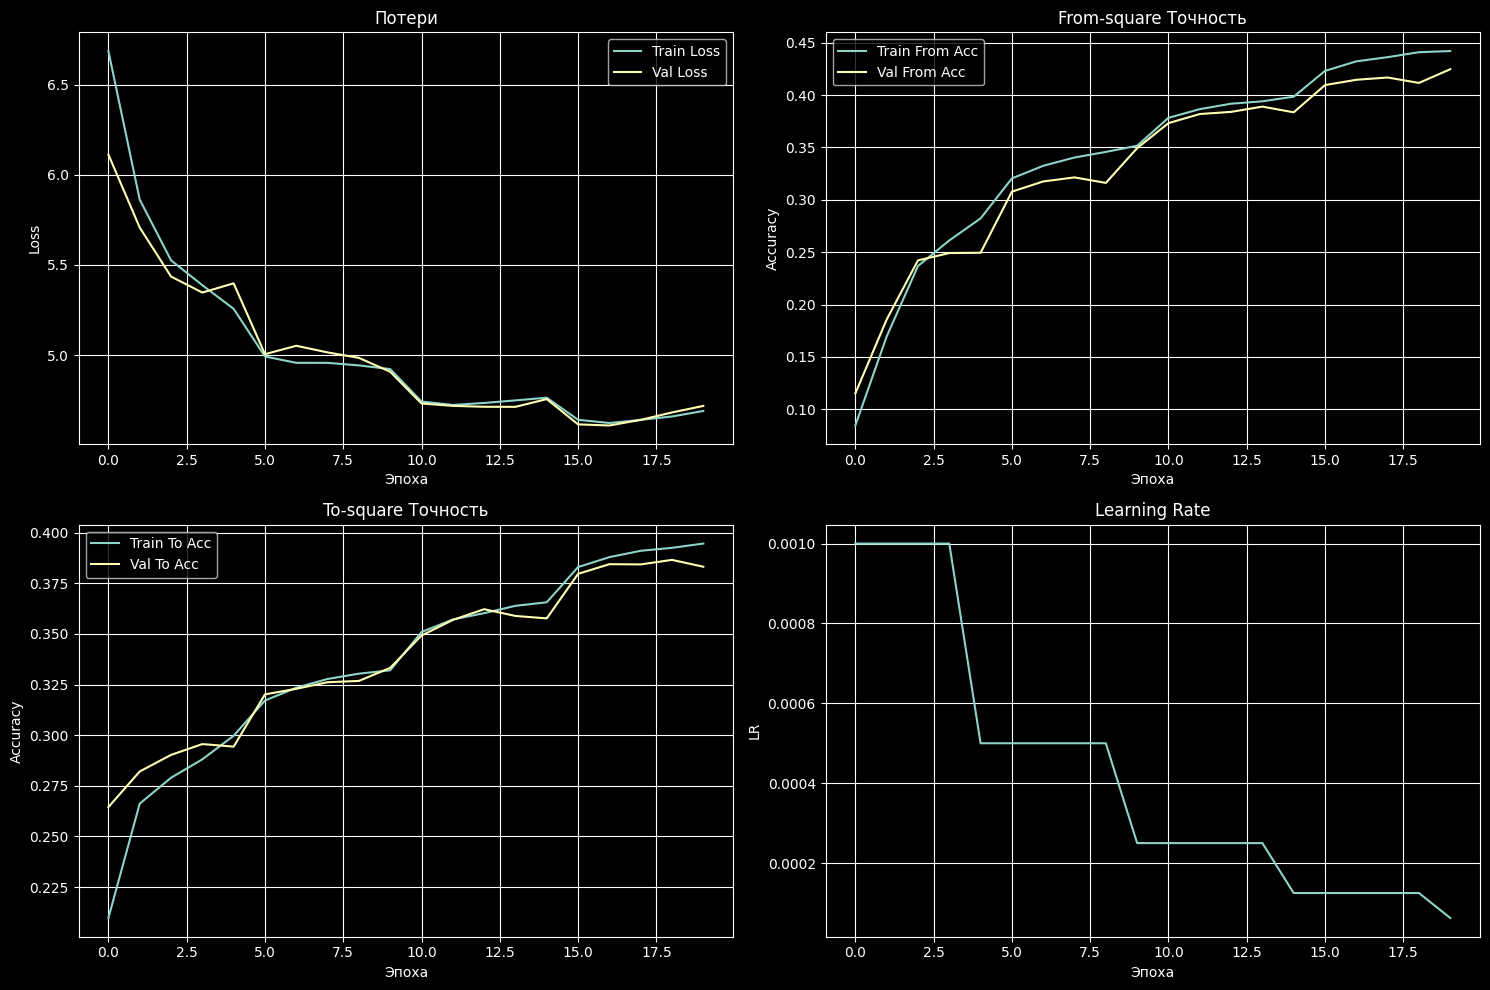

In [9]:
if __name__ == "__main__":
    main()